In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# View first 5 rows
print("First 5 rows of data:")
print(df.head())

# Check dataset shape
print(f"\nDataset has {df.shape[0]} rows and {df.shape[1]} columns")

# Check data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

First 5 rows of data:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  Stoc

In [2]:
# Check attrition distribution
print("Attrition Distribution:")
print(df['Attrition'].value_counts())

print("\nAttrition Percentage:")
print(df['Attrition'].value_counts(normalize=True) * 100)


Attrition Distribution:
Attrition
No     1233
Yes     237
Name: count, dtype: int64

Attrition Percentage:
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


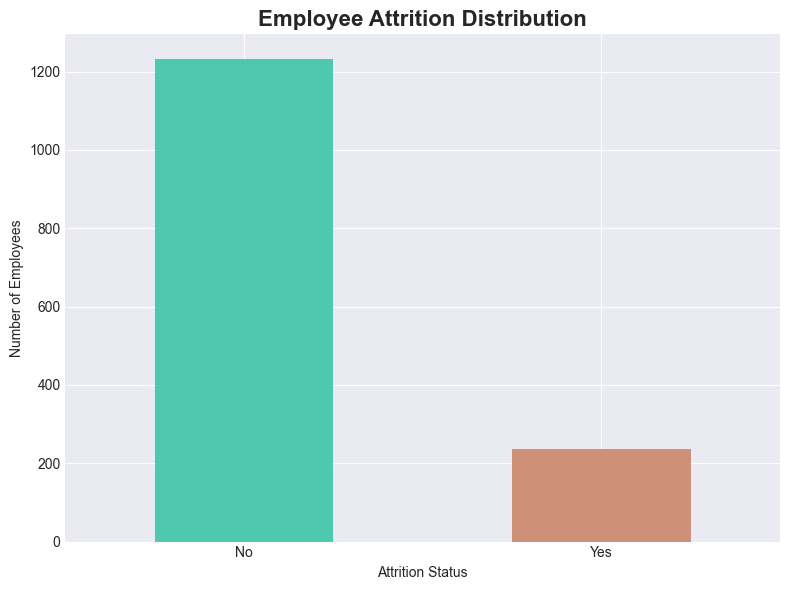

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Attrition distribution bar chart
plt.figure(figsize=(8, 6))
df['Attrition'].value_counts().plot(kind='bar', color=['#4ec9b0', '#ce9178'])
plt.title('Employee Attrition Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Attrition Status')
plt.ylabel('Number of Employees')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('attrition_distribution.png', dpi=300)
plt.show()

In [4]:
# Create a copy for preprocessing
data = df.copy()

# Remove unnecessary columns
# These columns have only one unique value - not useful for prediction
columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
data = data.drop(columns=columns_to_drop, errors='ignore')

print(f"Columns removed: {columns_to_drop}")
print(f"Remaining columns: {data.shape[1]}")

Columns removed: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
Remaining columns: 31


In [5]:
from sklearn.preprocessing import LabelEncoder

# Convert target variable to binary (0/1)
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

# Encode categorical features
label_encoders = {}
categorical_columns = data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    print(f"Encoded: {col}")

print(f"\nTotal categorical features encoded: {len(categorical_columns)}")


Encoded: BusinessTravel
Encoded: Department
Encoded: EducationField
Encoded: Gender
Encoded: JobRole
Encoded: MaritalStatus
Encoded: OverTime

Total categorical features encoded: 7


In [6]:
# Separate features (X) and target variable (y)
X = data.drop('Attrition', axis=1)  # All columns except Attrition
y = data['Attrition']               # Only Attrition column

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names:")
print(X.columns.tolist())


Features shape: (1470, 30)
Target shape: (1470,)

Feature names:
['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [7]:
from sklearn.model_selection import train_test_split

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class distribution
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 1176
Testing samples: 294


In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Before SMOTE:
Attrition
0    986
1    190
Name: count, dtype: int64

After SMOTE:
Attrition
0    986
1    986
Name: count, dtype: int64


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("Features scaled to mean=0, std=1")


Features scaled to mean=0, std=1


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize 5 different models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
}

# Train each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    print(f"✓ {name} - Accuracy: {accuracy:.3f}, ROC-AUC: {roc_auc:.3f}\n")


Training Logistic Regression...
✓ Logistic Regression - Accuracy: 0.799, ROC-AUC: 0.718

Training Decision Tree...
✓ Decision Tree - Accuracy: 0.772, ROC-AUC: 0.673

Training Random Forest...
✓ Random Forest - Accuracy: 0.799, ROC-AUC: 0.738

Training Gradient Boosting...
✓ Gradient Boosting - Accuracy: 0.803, ROC-AUC: 0.752

Training XGBoost...
✓ XGBoost - Accuracy: 0.827, ROC-AUC: 0.741



In [11]:
# Create comparison table
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("Model Performance Comparison:")
print(comparison_df)

# Find best model
best_model_name = comparison_df['ROC-AUC'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"ROC-AUC: {comparison_df.loc[best_model_name, 'ROC-AUC']:.4f}")


Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.7993     0.4000  0.5106    0.4486   0.7182
Decision Tree          0.7721     0.3611  0.5532    0.4370   0.6732
Random Forest          0.7993     0.3421  0.2766    0.3059   0.7378
Gradient Boosting      0.8027     0.4035  0.4894    0.4423   0.7518
XGBoost                0.8265     0.4444  0.3404    0.3855   0.7411

🏆 Best Model: Gradient Boosting
ROC-AUC: 0.7518


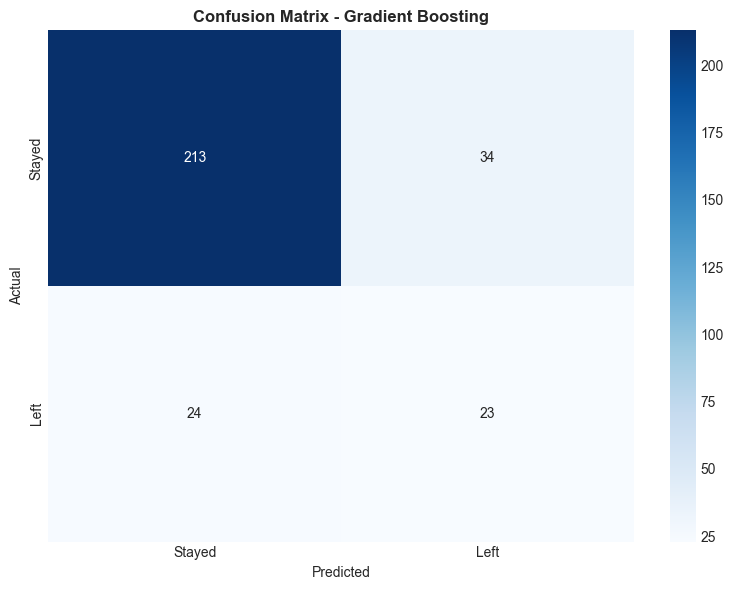

In [12]:
from sklearn.metrics import confusion_matrix

# Get best model predictions
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Left'],
            yticklabels=['Stayed', 'Left'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()


Top 10 Most Important Features:
                    Feature  Importance
22         StockOptionLevel    0.185953
13          JobSatisfaction    0.094058
7   EnvironmentSatisfaction    0.071073
11                 JobLevel    0.059596
29     YearsWithCurrManager    0.056001
10           JobInvolvement    0.055243
15            MonthlyIncome    0.046949
1            BusinessTravel    0.041823
14            MaritalStatus    0.039615
25          WorkLifeBalance    0.036421


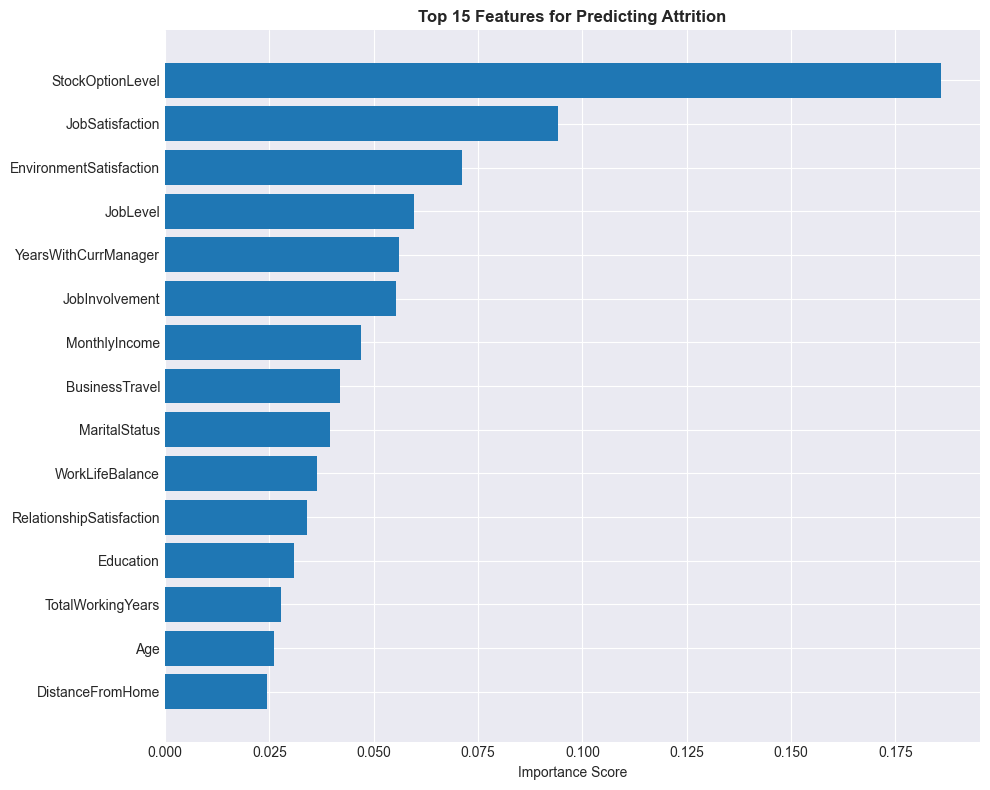

In [13]:
# Get feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    top_15 = feature_importance.head(15)
    plt.barh(range(len(top_15)), top_15['Importance'])
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Importance Score')
    plt.title('Top 15 Features for Predicting Attrition', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()


In [14]:
import joblib

# Save model, scaler, and encoders
joblib.dump(best_model, 'employee_attrition_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("✓ Model saved successfully!")
print("Files created:")
print("  - employee_attrition_model.pkl")
print("  - scaler.pkl")
print("  - label_encoders.pkl")


✓ Model saved successfully!
Files created:
  - employee_attrition_model.pkl
  - scaler.pkl
  - label_encoders.pkl


In [15]:
# Create comprehensive predictions dataset
predictions_df = X_test.copy()
predictions_df['Actual_Attrition'] = y_test.values
predictions_df['Predicted_Attrition'] = y_pred_best
predictions_df['Attrition_Probability'] = best_model.predict_proba(X_test_scaled)[:, 1]

# Categorize risk levels
predictions_df['Risk_Category'] = pd.cut(
    predictions_df['Attrition_Probability'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Save to CSV for Power BI
predictions_df.to_csv('Data/Predicted-Data/employee_predictions.csv', index=False)

print(f"✓ Predictions saved: {len(predictions_df)} employees")
print("\nRisk Distribution:")
print(predictions_df['Risk_Category'].value_counts())


✓ Predictions saved: 294 employees

Risk Distribution:
Risk_Category
Low Risk       203
Medium Risk     63
High Risk       28
Name: count, dtype: int64
